In [23]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
from pathlib import Path

# Establish path to workgroup data folder
FILEPATH = Path('/Volumes/WRKGRP/STD-FSW-BSI-SD-Movement_Tracking/dsp/data/02_interim')

# Load dataframe
master = pd.read_excel(FILEPATH / 'dataset_partial_2025-05-14_15-20.xlsx')

# Hypotheses

❗️ Copied from original methods.md file

* **Hypothesis 1:** Higher IOP positively correlates with higher STRS and SPARTS.
    * **IV**: IOP response (**ordinal**, 3 levels: less often, average, more often)
    * **DV 1:** STRS response (**continuous**, range ?)
    * **DV 2:** SPARTS response (**continuous**, range ?)
* **Hypothesis 2:** Higher IOP positively correlates with closer proximity. 
    * In plain words: check whether teacher actually visits students more when they report IOP 'More often'
    * *But how are we going to define proximity? Maybe determine a range for how many times a day teacher approached student (also need to determine how long they need to stay next to the student to count as approaching), and how much time total the teacher spent close to student?--MC, 11-04-2025*
    * **16-05-2025**
        * IV: IOP response (**ordinal**, 3 levels: less often, average, more often)
        * DV: N times a teacher was in close proximity to a student (**continuous**, derived from XYZ)
        * Suggested analysis: Linear Mixed-Effects Models
            * IOP as predictor of N (XYZ)
            * ...?
* **Hypothesis 3:** Higher implicit proximity (XYZ) correlates with higher STRS and SPARTS.
    * Should this just be part of the above hypothesis, instead of separate? Not sure anymore what we're trying to answer. (Maja, 16-05-2025)


**Note to self**
* **Unilateral relationships:** need only teacher score or only student score.
* **Bilateral relationships:** need both teacher and student score.

# Data prep

## IOP
Scores are translated to English and turned into an ordinal variable (pd.Categorical) ranging from *Less often* to *More often*.  

In [24]:
print(f"IOP unique entries before data prep: {master['iop'].unique()}")

# Replace Dutch values with English
master['iop'] = master['iop'].replace({'Minder vaak': 'Less often', 'Gemiddeld': 'Average', 'Vaker': 'More often'})

# Define a categorical order
iop_order = ["Less often", "Average", "More often"]
master['iop'] = pd.Categorical(master['iop'], iop_order, ordered=True)

print(f"IOP unique entries after data prep: {master['iop'].unique()}")

IOP unique entries before data prep: ['Minder vaak' 'Vaker' 'Gemiddeld' nan]
IOP unique entries after data prep: ['Less often', 'More often', 'Average', NaN]
Categories (3, object): ['Less often' < 'Average' < 'More often']



# SPARTS
## Summary statistics and distribution

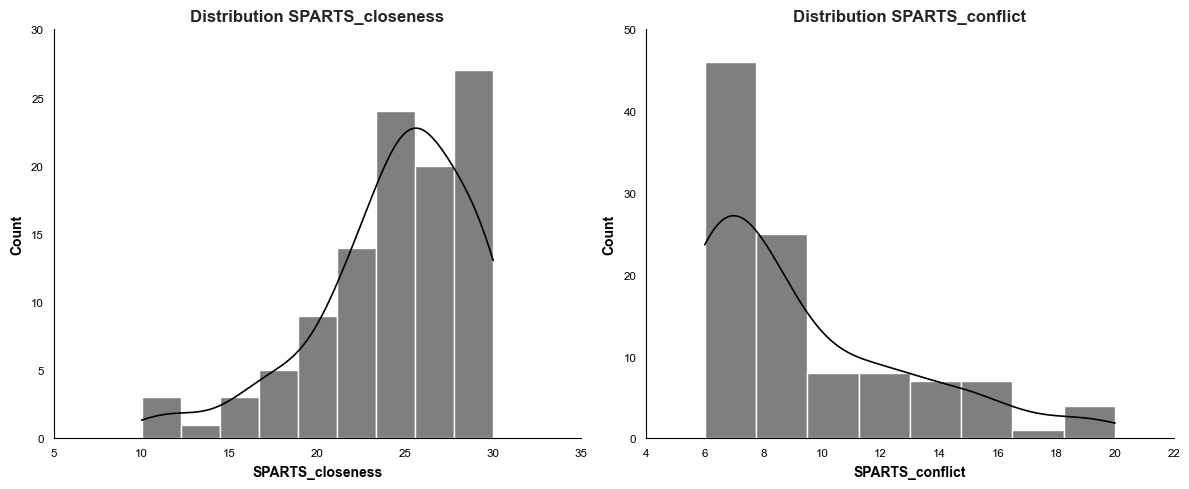

In [16]:
# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

sns.histplot(
    data=master,
    x='SPARTS_closeness',
    kde=True,
    ax=axes[0]  # Plot on subplot 1
)
axes[0].set_title('Distribution SPARTS_closeness')

sns.histplot(
    data=master,
    x='SPARTS_conflict',
    kde = True,
    ax=axes[1]  # Plot on subplot 2
)
axes[1].set_title('Distribution SPARTS_conflict')

plt.tight_layout()
plt.show()

## Normalized scores

Just a first attempt at normalizing the scores here to use in comparison with other scores. Sample st dev used instead of population, as I'm assuming we're generalizing these results (do correct me if I'm wrong). 

In [15]:
from scipy.stats import zscore

master['zSPARTS_total'] = zscore(master['SPARTS_total'], ddof=1)  # Sample population st dev; generalization
# outliers = sparts[np.abs(sparts['SPARTS_total_z']) > 3]
# print(f"Number of outliers (|z| > 3): {len(outliers)}")
master['zSPARTS_total'].describe()

count    1.060000e+02
mean     3.351617e-17
std      1.000000e+00
min     -3.354329e+00
25%     -5.362987e-01
50%      2.638826e-01
75%      7.857400e-01
max      1.238016e+00
Name: zSPARTS_total, dtype: float64

# Plots

**29-05-2025:** Taking Oliver's final `filtered_dataset` and running basic statistics for the paper here. 

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date

data = pd.read_excel("/Volumes/WRKGRP/STD-FSW-BSI-SD-Movement_Tracking/dsp/data/03_processed/dataset-total_2025-05-19_00-10.xlsx")

# ---After filtering---
# Filter out rows with missing values in 'IOP' or 'full_category' columns, as well as 9999 values
data = data.dropna(subset=['IOP', 'full_category'])
data = data[data['IOP'] != 9999]

## IOP

In [26]:
# Replace numerical IOP values with pd.Categorical for easier reading and plotting
data['IOP'] = data['IOP'].replace({1: 'Less often', 2: 'Average', 3: 'More often'})

# Define a categorical order
iop_order = ["Less often", "Average", "More often"]
data['IOP'] = pd.Categorical(data['IOP'], iop_order, ordered=True)

Compute frequency statistics.

In [57]:
print('IOP response frequency per classroom (teacher)')
display(pd.crosstab(data['class'], data['IOP'], margins=True, margins_name='Total n'))

print('IOP response frequency per classroom (teacher) in %')
display((pd.crosstab(data['class'], data['IOP'], margins=True, margins_name='Total %', normalize='index') * 100).round(2))

IOP response frequency per classroom (teacher)


IOP,Less often,Average,More often,Total n
class,,,,
102,4,4,4,12
103,7,13,8,28
104,1,8,1,10
105,0,10,10,20
106,0,4,8,12
108,4,5,4,13
Total n,16,44,35,95


IOP response frequency per classroom (teacher) in %


IOP,Less often,Average,More often
class,,,
102,33.33,33.33,33.33
103,25.00,46.43,28.57
104,10.00,80.00,10.00
105,0.00,50.00,50.00
106,0.00,33.33,66.67
108,30.77,38.46,30.77
Total %,16.84,46.32,36.84


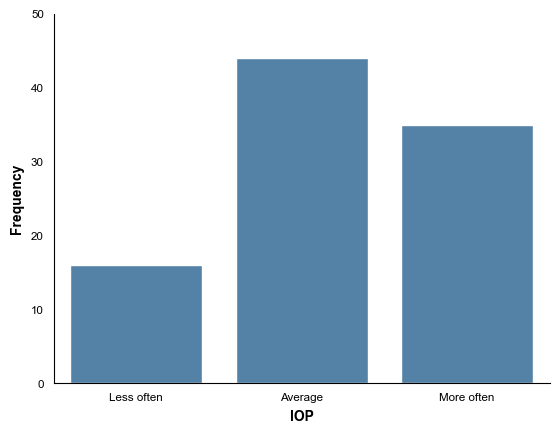

In [32]:
# Load APA 7th ed. style (steelblue color) for plots
plt.style.use('/plots/apa7.mplstyle')

today = date.today().strftime("%Y-%m-%d")

sns.countplot(x='IOP', data=data)
# plt.title('IOP response frequency')
plt.ylabel('Frequency')
plt.xlabel('IOP')

# plt.figtext(0.5, 0.01, f'Generated: Maja Culjak, {today}', ha='center', fontsize=9, color='gray')  # Add caption
# plt.tight_layout(rect=[0, 0.03, 1, 1])  # Make space in bottom for caption

plt.show()

## SPARTS

In [82]:
print('Descriptives for SPARTS_total scores:')
display(data['SPARTS_total'].describe())

Descriptives for SPARTS_total scores:


count    91.000000
mean     27.076923
std       2.291195
min      22.000000
25%      26.000000
50%      27.000000
75%      28.500000
max      33.000000
Name: SPARTS_total, dtype: float64

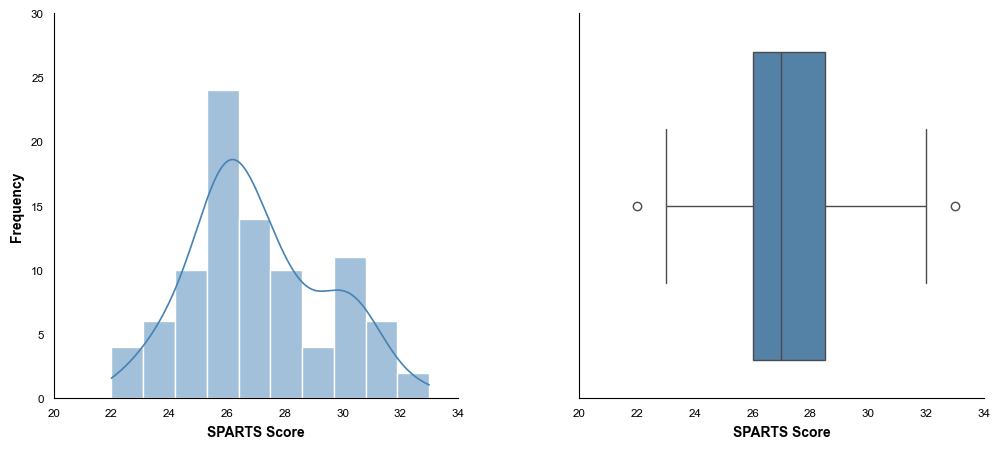

In [27]:
# Load APA 7th ed. style (steelblue color) for plots
plt.style.use('/plots/apa7.mplstyle')

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Histogram
sns.histplot(
    data=data,
    x='SPARTS_total',
    kde=True,
    ax=axes[0]
)
# axes[0].set_title('Frequency Distribution SPARTS totascores')
axes[0].set_xlabel('SPARTS Score')
axes[0].set_ylabel('Frequency') 

# Boxplot
sns.boxplot(
    data=data,
    x='SPARTS_total',
    ax=axes[1]
)

# axes[1].set_title('Value distribution of SPARTS total scores')
axes[1].set_xlabel('SPARTS Score')

# plt.figtext(0.5, 0.01, f'Generated: Maja Culjak, {today}', ha='center', fontsize=9, color='gray')  # Add caption
# plt.tight_layout(rect=[0, 0.03, 1, 1])  # Make space in bottom for caption

plt.show()

## STRS

In [83]:
print('Descriptives for STRS_total scores:')
display(data['STRS_total'].describe())

Descriptives for STRS_total scores:


count    95.000000
mean     41.252632
std       5.042307
min      28.000000
25%      39.000000
50%      42.000000
75%      45.000000
max      50.000000
Name: STRS_total, dtype: float64

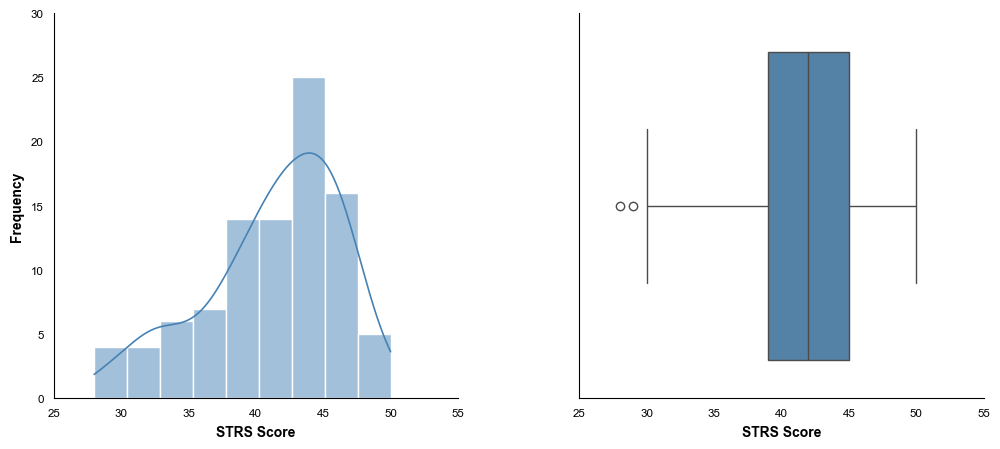

In [28]:
# Load APA 7th ed. style (steelblue color) for plots
plt.style.use('/plots/apa7.mplstyle')

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Histogram
sns.histplot(
    data=data,
    x='STRS_total',
    kde=True,
    ax=axes[0]
)
# axes[0].set_title('Frequency distribution of STRS total scores')
axes[0].set_xlabel('STRS Score')
axes[0].set_ylabel('Frequency')

# Boxplot
sns.boxplot(
    data=data,
    x='STRS_total',
    ax=axes[1]
)
# axes[1].set_title('Value distribution of STRS total scores')
axes[1].set_xlabel('STRS Score')

# plt.figtext(0.5, 0.01, f'Generated: Maja Culjak, {today}', ha='center', fontsize=9, color='gray')  # Add caption
# plt.tight_layout(rect=[0, 0.03, 1, 1])  # Make space in bottom for caption

plt.show()